#If this file does not work in the local setup, I am requesting to try the google colab link:

https://colab.research.google.com/drive/1qw2c0o5JHtvA3vhnjUf9VDdJ5DRzlHWE?usp=sharing

#Installation

In [37]:
!pip install lightgbm==4.5.0
!pip install optuna

Found existing installation: lightgbm 4.5.0
Uninstalling lightgbm-4.5.0:
  Successfully uninstalled lightgbm-4.5.0
  Using cached lightgbm-4.5.0-py3-none-manylinux_2_28_x86_64.whl.metadata (17 kB)
Using cached lightgbm-4.5.0-py3-none-manylinux_2_28_x86_64.whl (3.6 MB)


In [38]:
import pandas as pd
import numpy as np

# === Machine Learning ===
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

from statsmodels.tsa.seasonal import seasonal_decompose

# LightGBM
import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation

# === Visualization ===
import matplotlib.pyplot as plt
import seaborn as sns

import holidays
import optuna

# Set a default style for visualizations
sns.set(style="whitegrid")

# === Other Utilities ===
import warnings
warnings.filterwarnings("ignore")  # Suppress warnings (if needed)

#Dataframe create, checking and filling missing values

In [39]:
url = "https://raw.githubusercontent.com/woltapp/applied-science-internship-2025/refs/heads/main/daily_cp_activity_dataset.csv"
df = pd.read_csv(url)
df.head()

,date,courier_partners_online,temperature,relative_humidity,precipitation
0,2021-05-01,49,18.27,0.57,0.0
1,2021-05-02,927,19.88,0.55,0.0
2,2021-05-03,40,16.88,0.60,0.0
3,2021-05-04,51,21.88,0.53,0.0
4,2021-05-05,50,21.11,0.54,0.0


In [40]:
df.columns

Index(['date', 'courier_partners_online', 'temperature', 'relative_humidity',
       'precipitation'],
      dtype='object')

In [41]:
df.shape

(761, 5)

In [42]:
df.isnull().sum()

,0
date,0
courier_partners_online,0
temperature,30
relative_humidity,0
precipitation,5


In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 761 entries, 0 to 760
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   date                     761 non-null    object 
 1   courier_partners_online  761 non-null    int64  
 2   temperature              731 non-null    float64
 3   relative_humidity        761 non-null    float64
 4   precipitation            756 non-null    float64
dtypes: float64(3), int64(1), object(1)
memory usage: 29.9+ KB


In [44]:
df = df.fillna(method='ffill')

In [45]:
df.isnull().sum()

,0
date,0
courier_partners_online,0
temperature,0
relative_humidity,0
precipitation,0


In [46]:
df.describe()

,courier_partners_online,temperature,relative_humidity,precipitation
count,761.000000,761.000000,761.000000,761.000000
mean,72.417871,17.498765,0.653193,0.917608
std,96.039679,9.965979,0.171553,1.758312
min,34.000000,-9.980000,0.430000,0.000000
25%,58.000000,10.860000,0.520000,0.000000
50%,66.000000,18.500000,0.590000,0.000000
75%,72.000000,24.400000,0.790000,0.910000
max,1506.000000,37.950000,1.000000,12.900000


In [47]:
max_cpo_date = df.loc[df['courier_partners_online'].idxmax(), 'date']
min_cpo_date = df.loc[df['courier_partners_online'].idxmin(), 'date']

print(f"Maximum CPO Date: {max_cpo_date}")
print(f"Minimum CPO Date: {min_cpo_date}")

Maximum CPO Date: 2022-03-23
Minimum CPO Date: 2021-06-04


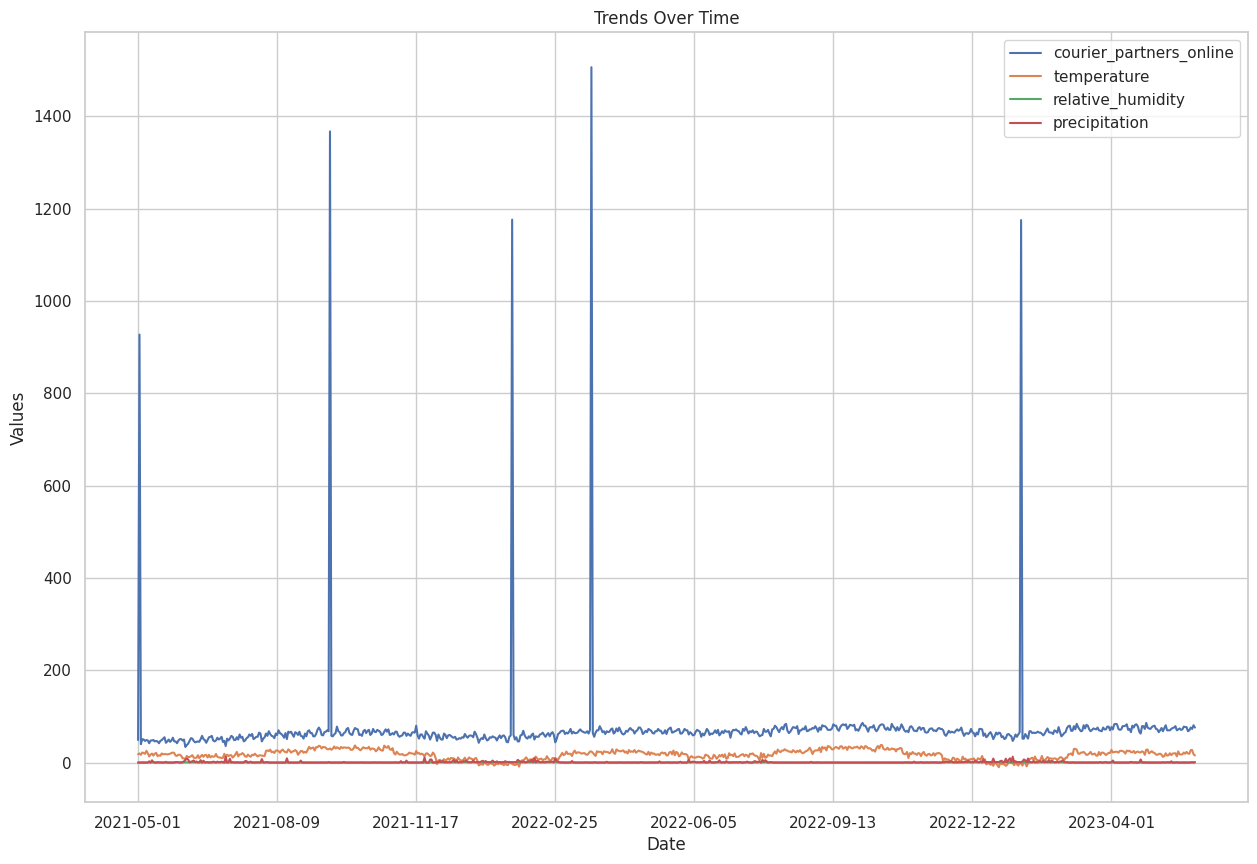

In [48]:
# Plot time series
df.set_index('date')[['courier_partners_online', 'temperature', 'relative_humidity', 'precipitation']].plot(figsize=(15, 10))
plt.title("Trends Over Time")
plt.ylabel("Values")
plt.xlabel("Date")
plt.show()


#Removing outliers

Number of outliers detected in courier_partners_online: 7


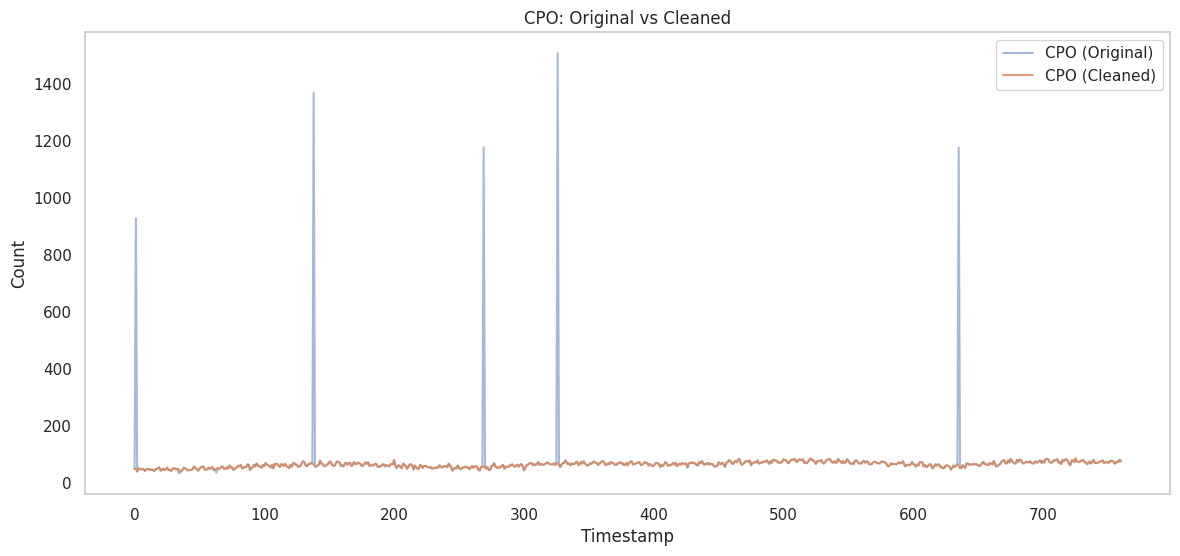

In [49]:
# Function to detect and remove outliers using the IQR method
def remove_outliers_iqr(data, column, threshold=1.5):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - threshold * IQR
    upper_bound = Q3 + threshold * IQR

    outliers = (data[column] < lower_bound) | (data[column] > upper_bound)
    print(f"Number of outliers detected in {column}: {outliers.sum()}")

    data.loc[outliers, column] = np.nan

    data[column] = data[column].fillna(data[column].rolling(window=24, min_periods=1).median())

    return data

df_cleaned = df.copy()
df_cleaned = remove_outliers_iqr(df_cleaned, 'courier_partners_online')

# Plot original vs cleaned data
plt.figure(figsize=(14, 6))
plt.plot(df['courier_partners_online'], label='CPO (Original)', alpha=0.5)
plt.plot(df_cleaned['courier_partners_online'], label='CPO (Cleaned)', alpha=0.8)
plt.title("CPO: Original vs Cleaned")
plt.xlabel("Timestamp")
plt.ylabel("Count")
plt.legend()
plt.grid()
plt.show()

In [50]:
df_cleaned.head()

,date,courier_partners_online,temperature,relative_humidity,precipitation
0,2021-05-01,49.0,18.27,0.57,0.0
1,2021-05-02,49.0,19.88,0.55,0.0
2,2021-05-03,40.0,16.88,0.60,0.0
3,2021-05-04,51.0,21.88,0.53,0.0
4,2021-05-05,50.0,21.11,0.54,0.0


In [51]:
df_cleaned["courier_partners_online"] = df_cleaned["courier_partners_online"].astype(int)

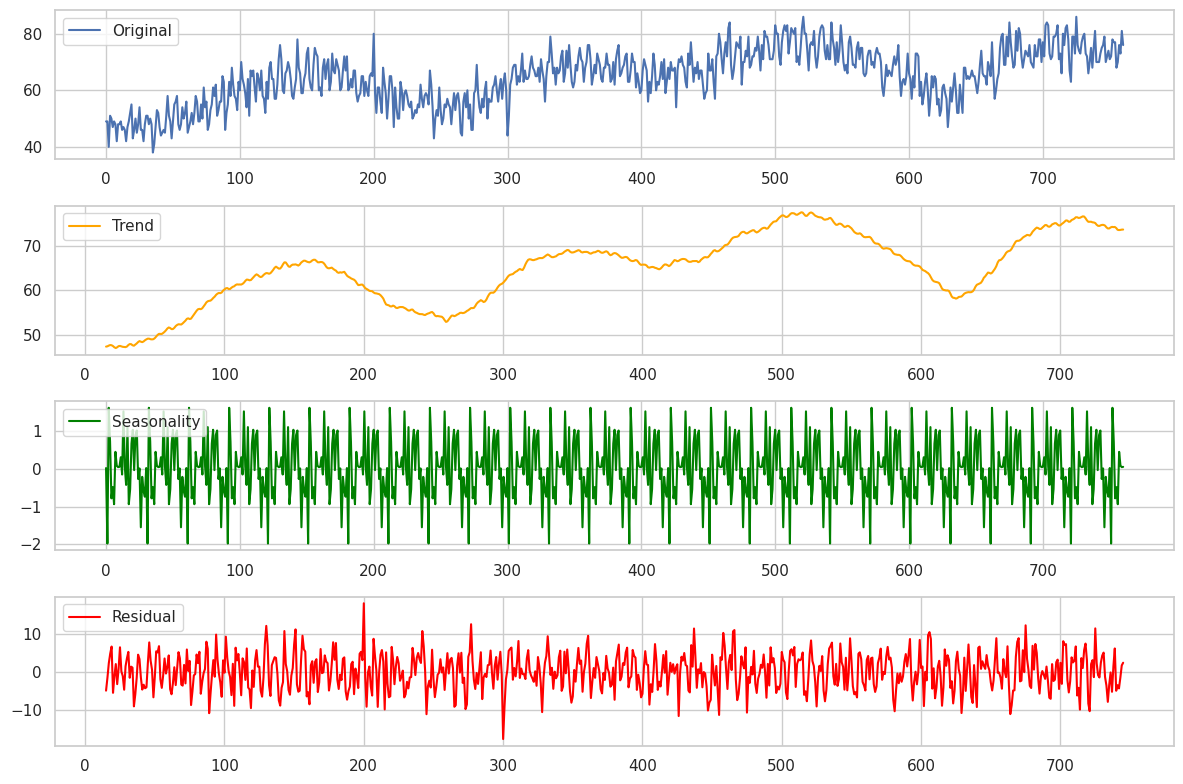

In [52]:
# Perform seasonal decomposition on CPO
frequency = 30
decompose_cpo = seasonal_decompose(df_cleaned['courier_partners_online'], model='additive', period=frequency)

# Plot the decomposition for 'CPO'
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(df_cleaned['courier_partners_online'], label='Original')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(decompose_cpo.trend, label='Trend', color='orange')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(decompose_cpo.seasonal, label='Seasonality', color='green')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(decompose_cpo.resid, label='Residual', color='red')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

#Build a base model

In [53]:
basic_features = ['temperature', 'relative_humidity', 'precipitation']

cpo_count = 'courier_partners_online'

X_basic = df_cleaned[basic_features]
y_cpo = df_cleaned[cpo_count]

X_train, X_test, y_train_cpo, y_test_cpo = train_test_split(X_basic, y_cpo, test_size=30, random_state=42)

train_data_cpo = lgb.Dataset(X_train, label=y_train_cpo)
test_data_cpo = lgb.Dataset(X_test, label=y_test_cpo, reference=train_data_cpo)

params_basic = {
    'objective': 'regression',
    'metric': 'mae',
    'learning_rate': 0.1,
    'max_depth': 6,
    'num_leaves': 31,
    'verbosity': -1
}

model_basic = lgb.train(
    params_basic,
    train_data_cpo,
    num_boost_round=500,
    valid_sets=[test_data_cpo],
    valid_names=['valid']
)

pred_cpo = model_basic.predict(X_test, num_iteration=model_basic.best_iteration)

mae_basic = mean_absolute_error(y_test_cpo, pred_cpo)
r2_basic = r2_score(y_test_cpo, pred_cpo)

print(f"Minimal Model MAE: {mae_basic}")
print(f"Minimal Model R²: {r2_basic}")

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_cpo = mape(y_test_cpo, pred_cpo)
print(f"Minimal Model MAPE: {mape_cpo}%")

Minimal Model MAE: 6.438339943688789
Minimal Model R²: 0.28120197981686335
Minimal Model MAPE: 9.905696477344005%


#Extract feature from date time

In [54]:
def create_features_electricity(df):

    df = df.copy()

    df['date'] = pd.to_datetime(df['date'])

    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week

    X = df[['date', 'courier_partners_online',	'temperature',	'relative_humidity',
            'precipitation', 'dayofweek', 'quarter', 'month', 'year',
            'dayofyear', 'dayofmonth', 'weekofyear']]
    return X

df_exg = df_cleaned.copy()

df_exg = create_features_electricity(df_cleaned)

df_exg.head()

,date,courier_partners_online,temperature,relative_humidity,precipitation,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
0,2021-05-01,49,18.27,0.57,0.0,5,2,5,2021,121,1,17
1,2021-05-02,49,19.88,0.55,0.0,6,2,5,2021,122,2,17
2,2021-05-03,40,16.88,0.60,0.0,0,2,5,2021,123,3,18
3,2021-05-04,51,21.88,0.53,0.0,1,2,5,2021,124,4,18
4,2021-05-05,50,21.11,0.54,0.0,2,2,5,2021,125,5,18


In [55]:
df_exg.shape

(761, 12)

#Analyze the Data

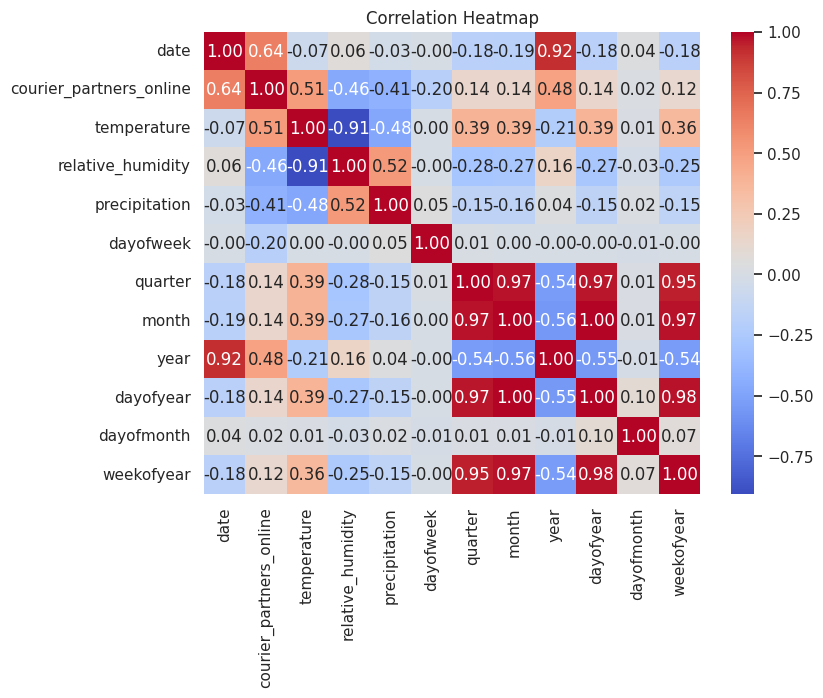

In [56]:
plt.figure(figsize=(8, 6))
sns.heatmap(df_exg.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Heatmap")
plt.show()

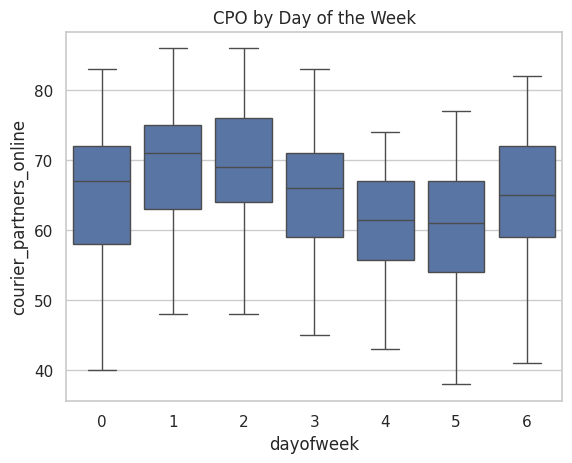

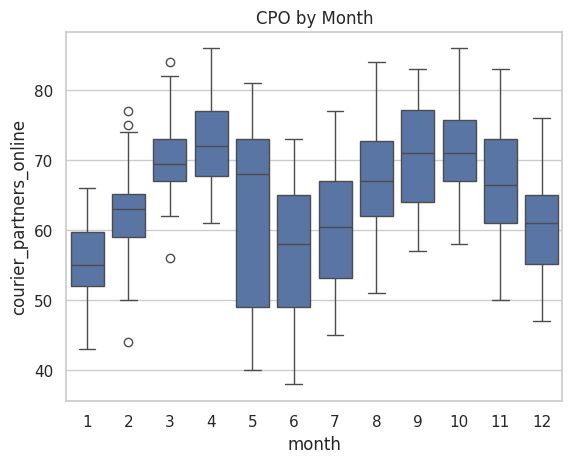

In [57]:
# Boxplot by day of the week
sns.boxplot(data=df_exg, x='dayofweek', y='courier_partners_online')
plt.title("CPO by Day of the Week")
plt.show()

# Boxplot by month
sns.boxplot(data=df_exg, x='month', y='courier_partners_online')
plt.title("CPO by Month")
plt.show()

In [58]:
# Average courier activity for days - 0:saturday. 1:sunday
dayofweek_mean = df_exg.groupby('dayofweek')['courier_partners_online'].mean()

print(dayofweek_mean)

dayofweek
0    65.192661
1    68.522936
2    69.275229
3    64.592593
4    60.425926
5    60.587156
6    64.660550
Name: courier_partners_online, dtype: float64


#Build and Train the model with new features

In [59]:
finland_holidays = holidays.Finland(years=[2021, 2022, 2023])
df_exg['is_public_holiday'] = df_exg['date'].apply(lambda x: 1 if x in finland_holidays else 0)

features = ['temperature',	'relative_humidity',
            'precipitation', 'dayofweek', 'quarter', 'month', 'year',
            'dayofyear', 'dayofmonth', 'weekofyear', 'is_public_holiday']

cpo_count = 'courier_partners_online'


X = df_exg[features]
y_cpo = df_exg[cpo_count]

X_train, X_test, y_train_cpo, y_test_cpo = train_test_split(X, y_cpo, test_size=30, random_state=42)

train_data_cpo = lgb.Dataset(X_train, label=y_train_cpo)
test_data_cpo = lgb.Dataset(X_test, label=y_test_cpo, reference=train_data_cpo)

params = {
    'objective': 'regression',
    'metric': ['mae', 'rmse'],
    'boosting_type': 'gbdt',
    'max_bin': 500,
    'max_depth': 6,
    'num_leaves': 31,
    'learning_rate': 0.03,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'min_data_in_leaf': 50,
    'lambda_l1': 0.1,
    'lambda_l2': 0.1,
    'min_gain_to_split': 0.02,
    'verbosity': -1,
}

# Train with early stopping
model_cpo = lgb.train(
    params,
    train_data_cpo,
    num_boost_round=2000,
    valid_sets=[test_data_cpo],
    valid_names=['valid'],
    callbacks=[
        lgb.early_stopping(stopping_rounds=20),
        lgb.log_evaluation(0)
    ]
)


# Predictions
pred_cpo = model_cpo.predict(X_test, num_iteration=model_cpo.best_iteration)

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[140]	valid's l1: 2.376	valid's rmse: 2.78564


In [60]:
mae_cpo = mean_absolute_error(y_test_cpo, pred_cpo)
print(f"CPO MAE: {mae_cpo}")

r2_cpo = r2_score(y_test_cpo, pred_cpo)
print(f"CPO R²: {r2_cpo}")

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_cpo = mape(y_test_cpo, pred_cpo)
print(f"CPO MAPE: {mape_cpo}%")

CPO MAE: 2.375996094406304
CPO R²: 0.9071743900762494
CPO MAPE: 3.6339007725308727%


In [69]:
def accuracy_within_threshold(y_true, y_pred, threshold):
    correct = np.abs(y_true - y_pred) <= threshold
    accuracy = np.mean(correct) * 100
    return accuracy

cpo_accuracy_by_threshold = accuracy_within_threshold(y_test_cpo, pred_cpo, threshold=3)
print(f"CPO within ± 5: {cpo_accuracy_by_threshold:.2f}%")

CPO within ± 5: 63.33%


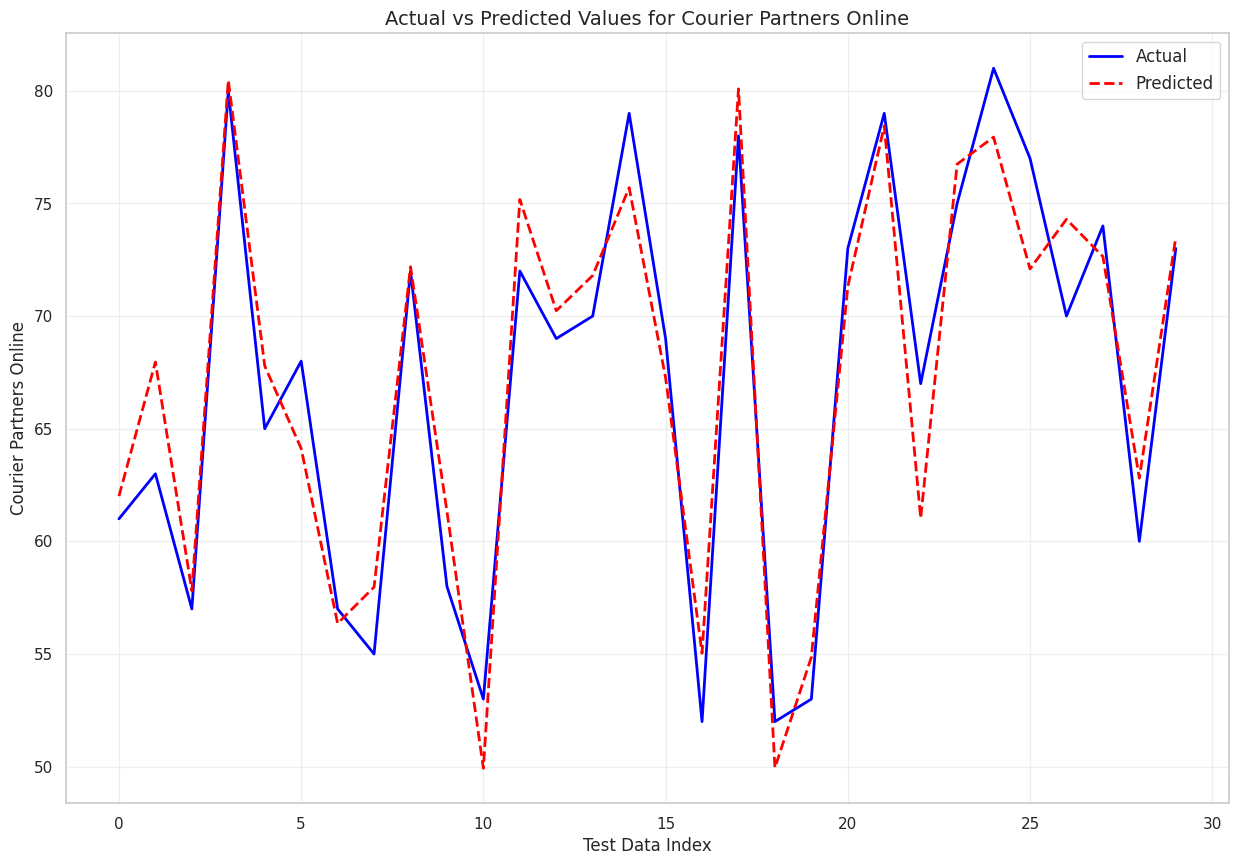

In [62]:
y_test_cpo = y_test_cpo.reset_index(drop=True)
plt.figure(figsize=(15, 10))
plt.plot(y_test_cpo, label="Actual", color="blue", linewidth=2)
plt.plot(pred_cpo, label="Predicted", color="red", linestyle="--", linewidth=2)
plt.title("Actual vs Predicted Values for Courier Partners Online", fontsize=14)
plt.xlabel("Test Data Index", fontsize=12)
plt.ylabel("Courier Partners Online", fontsize=12)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)

plt.show()


#Finding best params using optuna and update the model

In [63]:
def objective(trial):
    params = {
        'objective': 'regression',
        'metric': 'mae',
        'boosting_type': 'gbdt',
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'max_depth': trial.suggest_int('max_depth', 5, 15),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 50),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
    }

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    mae_scores = []

    for train_idx, valid_idx in kf.split(X_train):
        train_data = lgb.Dataset(X_train.iloc[train_idx], label=y_train_cpo.iloc[train_idx])
        valid_data = lgb.Dataset(X_train.iloc[valid_idx], label=y_train_cpo.iloc[valid_idx])
        model = lgb.train(params, train_data, valid_sets=[valid_data])
        pred = model.predict(X_train.iloc[valid_idx])
        mae_scores.append(mean_absolute_error(y_train_cpo.iloc[valid_idx], pred))

    return np.mean(mae_scores)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

[I 2025-01-25 14:55:01,511] A new study created in memory with name: no-name-43df9735-012b-485d-aadd-edb5d82ec77f
[I 2025-01-25 14:55:04,769] Trial 0 finished with value: 3.435156260294099 and parameters: {'num_leaves': 145, 'learning_rate': 0.019545595809447314, 'max_depth': 6, 'min_child_samples': 34, 'subsample': 0.7991219272769101, 'colsample_bytree': 0.933636072452948}. Best is trial 0 with value: 3.435156260294099.
[I 2025-01-25 14:55:07,143] Trial 1 finished with value: 2.834731768368555 and parameters: {'num_leaves': 104, 'learning_rate': 0.07488224696827553, 'max_depth': 7, 'min_child_samples': 11, 'subsample': 0.8405954472217805, 'colsample_bytree': 0.9168696233417937}. Best is trial 1 with value: 2.834731768368555.
[I 2025-01-25 14:55:07,323] Trial 2 finished with value: 2.7717032090324407 and parameters: {'num_leaves': 119, 'learning_rate': 0.08697391732747937, 'max_depth': 11, 'min_child_samples': 41, 'subsample': 0.9102770365100471, 'colsample_bytree': 0.9695752994863829}

In [64]:
X_train, X_test, y_train_cpo, y_test_cpo = train_test_split(X, y_cpo, test_size=30, random_state=42)

train_data_cpo = lgb.Dataset(X_train, label=y_train_cpo, params={'feature_pre_filter': False})
test_data_cpo = lgb.Dataset(X_test, label=y_test_cpo, reference=train_data_cpo, params={'feature_pre_filter': False})

best_params = study.best_params

best_params.update({
    'objective': 'regression',
    'metric': ['mae', 'rmse'],
    'verbosity': -1
})

model_cpo_optimized = lgb.train(
    best_params,
    train_data_cpo,
    num_boost_round=2000,
    valid_sets=[test_data_cpo],
    valid_names=['valid'],
    callbacks=[
        lgb.early_stopping(stopping_rounds=20),
        lgb.log_evaluation(0)
    ]
)


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[68]	valid's l1: 2.38878	valid's rmse: 2.93033


#Predict CPO for next 1 week

In [71]:
# Generate Dates to predict Future 1 week as we have data till 2023-05-31
future_dates = pd.date_range(start="2023-06-01", end="2023-06-07")

future_data = pd.DataFrame({'date': future_dates})

future_data['dayofweek'] = future_data['date'].dt.dayofweek
future_data['quarter'] = future_data['date'].dt.quarter
future_data['month'] = future_data['date'].dt.month
future_data['year'] = future_data['date'].dt.year
future_data['dayofyear'] = future_data['date'].dt.dayofyear
future_data['dayofmonth'] = future_data['date'].dt.day
future_data['weekofyear'] = future_data['date'].dt.isocalendar().week

future_data['is_public_holiday'] = future_data['date'].apply(
    lambda x: 1 if x in finland_holidays else 0
)

# Calculate rolling averages based on the last 7 days to fill exogenous features
rolling_means = df_exg[df_exg['date'] < '2023-06-01'].tail(7).mean()

future_data['temperature'] = rolling_means['temperature']
future_data['relative_humidity'] = rolling_means['relative_humidity']
future_data['precipitation'] = rolling_means['precipitation']


X_future = future_data[['temperature', 'relative_humidity', 'precipitation', 'dayofweek',
                        'quarter', 'month', 'year', 'dayofyear', 'dayofmonth', 'weekofyear', 'is_public_holiday']]

future_data['courier_partners_online'] = model_cpo.predict(X_future).astype(int)

print(future_data[['date', 'courier_partners_online']])

        date  courier_partners_online
0 2023-06-01                       73
1 2023-06-02                       70
2 2023-06-03                       71
3 2023-06-04                       73
4 2023-06-05                       74
5 2023-06-06                       77
6 2023-06-07                       77
